In [7]:
!pip install sentence_transformers

  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 10.4/10.4 MB 58.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 46.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   -- ------------------------------------- 15.7/212.5 MB 76.2 MB/s eta 0:00:03
   ------ --------------------------------- 35.4/212.5 MB 83.2 MB/s eta 0:00:03
   --------- ------------------------------ 50.6/212.5 MB 82.6 MB/s eta 0:00:02
   ------------- -------------------------- 73.1/212.5 MB 88.0 MB/s eta 0:00:02
   ------------------ --------------------- 96.2/212.5 MB 93.1 MB/s eta 0:00:02
   --------------------- ---------------

In [8]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

d:\projeto-pln\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


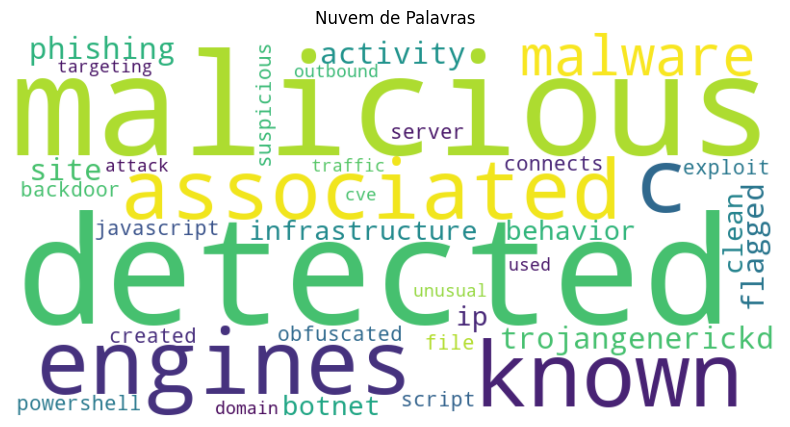

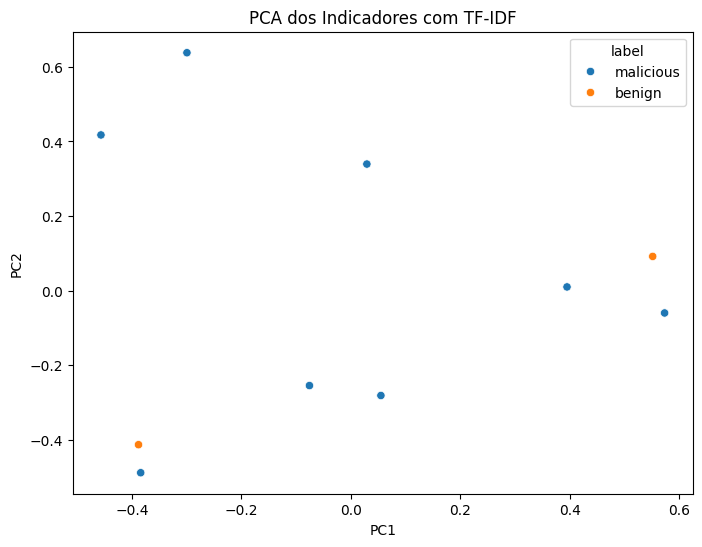

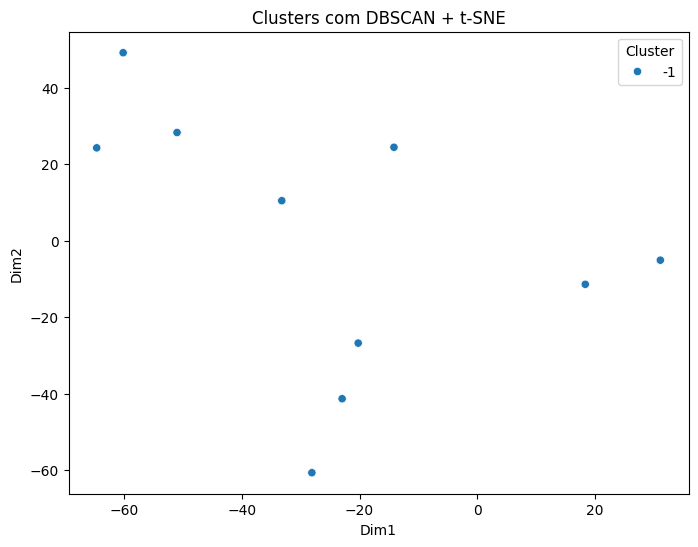

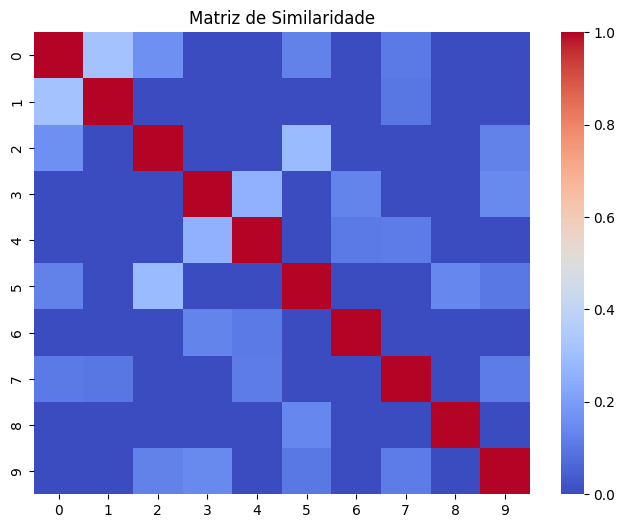

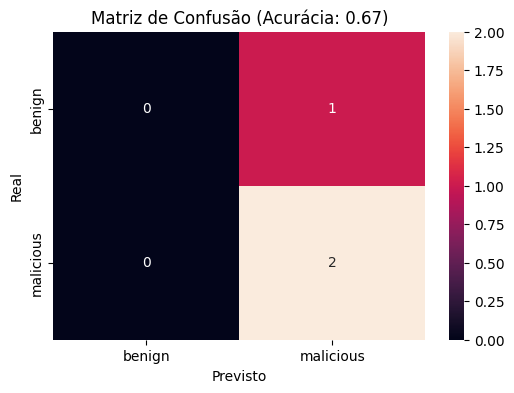

In [10]:
amples = [
    "Detected as Trojan.GenericKD by 35 engines.",
    "Phishing site flagged by 22 engines.",
    "No malicious activity detected.",
    "Known C2 infrastructure associated with botnet.",
    "Clean IP. Not associated with any malware.",
    "Malicious behavior detected in PowerShell script.",
    "Suspicious file with obfuscated JavaScript.",
    "Backdoor created by the malware connects to C2 server.",
    "Exploit targeting CVE-2023-1234 used in attack.",
    "Unusual outbound traffic to known malicious domain."
]
labels = ["malicious", "malicious", "benign", "malicious", "benign", "malicious", "malicious", "malicious", "malicious", "malicious"]

# Pré-processamento simples
def preprocess(text):
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r"\b\d{1,3}(\.\d{1,3}){3}\b", '', text)  # IPs
    text = re.sub(r"\b[a-fA-F0-9]{32,}\b", '', text)       # Hashes
    text = re.sub(r"[^a-zA-Z\s]", '', text)                # Remove pontuação
    return text.lower()

processed = [preprocess(t) for t in samples]

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(processed))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras")
plt.show()

# Vetorização TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(processed)

# Redução PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label")
plt.title("PCA dos Indicadores com TF-IDF")
plt.show()

# Clustering com DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=2)
clusters = dbscan.fit_predict(X_tfidf.toarray())

# Redução t-SNE para visualização
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())
tsne_df = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
tsne_df["Cluster"] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="Cluster", palette="tab10")
plt.title("Clusters com DBSCAN + t-SNE")
plt.show()

# Similaridade
sim_matrix = cosine_similarity(X_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, cmap="coolwarm")
plt.title("Matriz de Similaridade")
plt.show()

# Classificação com Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.3, stratify=labels, random_state=42)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Avaliação
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title(f"Matriz de Confusão (Acurácia: {acc:.2f})")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [11]:
dbscan = DBSCAN(eps=0.8, min_samples=2)
clusters = dbscan.fit_predict(X_tfidf.toarray())

<Axes: xlabel='Dim1', ylabel='Dim2'>

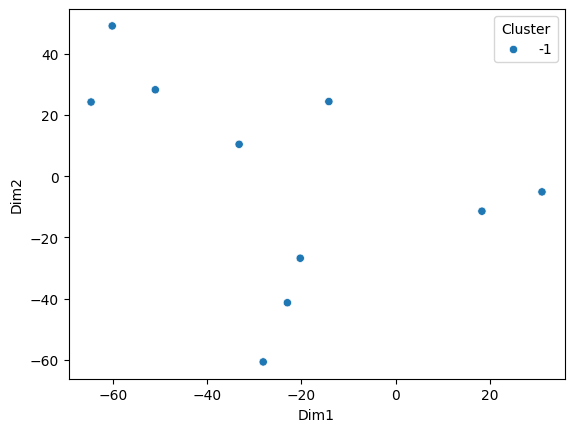

In [12]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="Cluster", palette="tab10")


In [13]:
from sklearn.decomposition import NMF

# Número de tópicos desejado (ajustável)
n_topics = 3

# Aplicar NMF sobre a matriz TF-IDF
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X_tfidf)
H = nmf.components_

# Palavras principais por tópico
feature_names = vectorizer.get_feature_names_out()
n_top_words = 6

print("\n--- Tópicos Descobertos ---")
for topic_idx, topic in enumerate(H):
    top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Tópico {topic_idx + 1}: {', '.join(top_features)}")


--- Tópicos Descobertos ---
Tópico 1: malicious, detected, no, activity, in, script
Tópico 2: with, associated, known, botnet, infrastructure, not
Tópico 3: by, engines, site, phishing, flagged, trojangenerickd


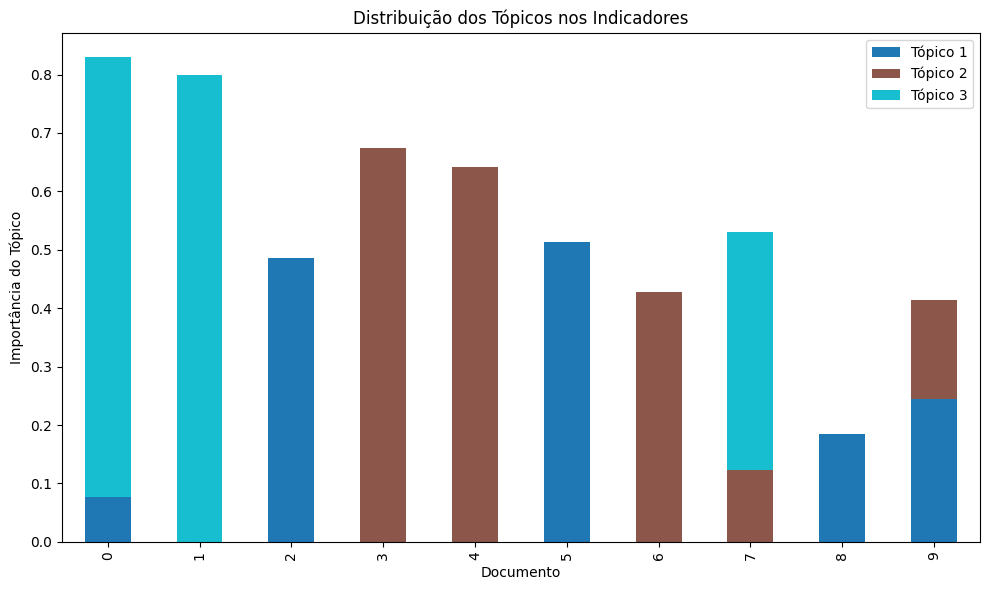

In [14]:
topic_df = pd.DataFrame(W, columns=[f'Tópico {i+1}' for i in range(n_topics)])
topic_df['Texto'] = samples

# Gráfico: peso de cada tópico por documento
topic_df.drop('Texto', axis=1).plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab10')
plt.title("Distribuição dos Tópicos nos Indicadores")
plt.xlabel("Documento")
plt.ylabel("Importância do Tópico")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [18]:
import json
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
vetorizador_tf = CountVectorizer(max_df=0.5, min_df=3)

with open("./assets/report.txt", "r", encoding="utf-8") as f:
        data = json.load(f)

nlp = spacy.load("en_core_web_sm")

texto_tokenizados = nlp(data)

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'dict'>